<a href="https://colab.research.google.com/github/AvitanshB/GameRush/blob/main/BrainTumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports Libraries and Models

In [ ]:
import os  # For interacting with the operating system (e.g., file paths)
import numpy as np  # For numerical operations, especially arrays and matrices
import random  # For random operations like shuffling data
from PIL import Image, ImageEnhance  # For image loading and enhancements
from tensorflow.keras.preprocessing.image import load_img  # For loading images in a format compatible with Keras

# Importing required modules from Keras
from tensorflow.keras.models import Sequential  # Sequential model to stack layers
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten  # Layers used to build the model
from tensorflow.keras.optimizers import Adam  # Optimizer used for training
from tensorflow.keras.applications import VGG16  # Pretrained VGG16 model for transfer learning
from sklearn.utils import shuffle  # To shuffle the data randomly

Load Data Set

In [ ]:
# Directories for training and testing data
train_dir = '/content/drive/MyDrive/MRI Images/Training/'
test_dir = '/content/drive/MyDrive/MRI Images/Testing/'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

Data Vizualiztion


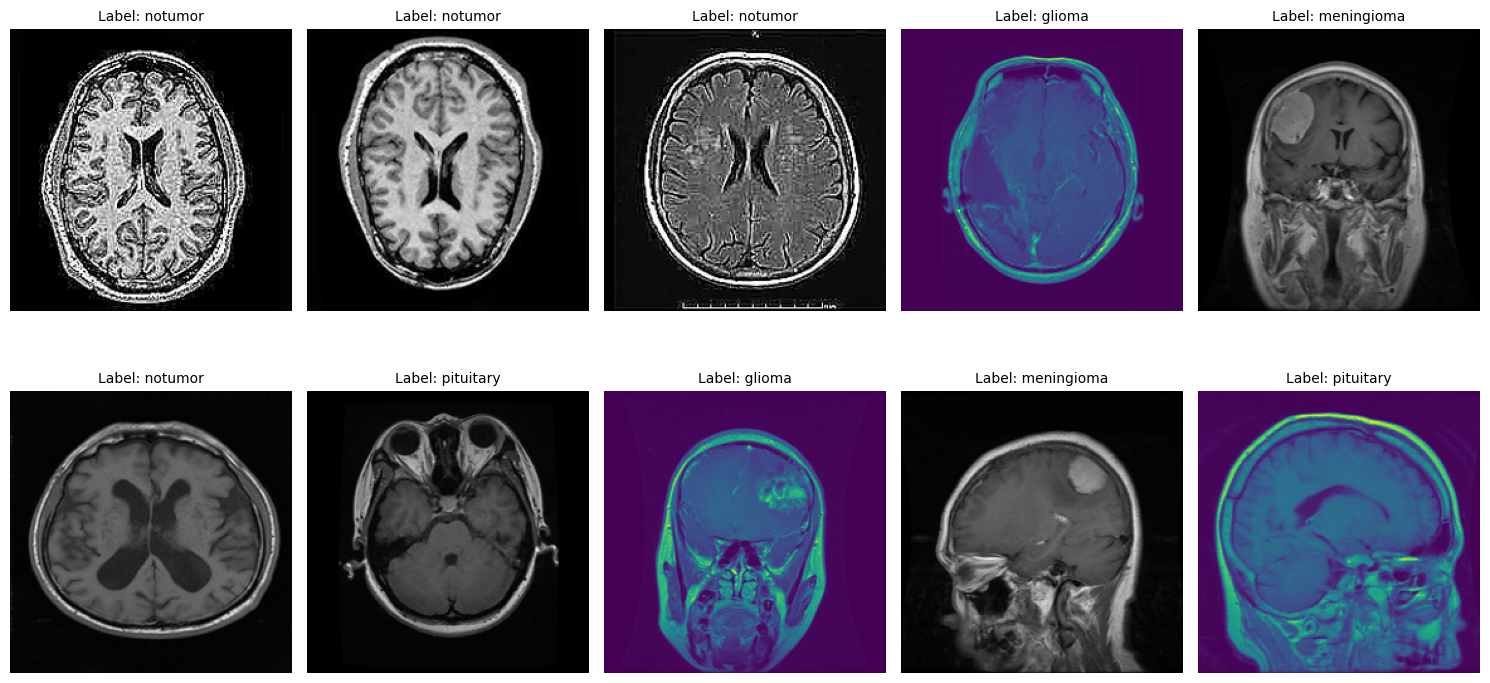

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    # Display class label in the second row
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

Image processing

In [ ]:
# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    unique_labels = os.listdir(train_dir)  # Ensure unique labels are determined
    encoded = [unique_labels.index(label) for label in labels]
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch

MODEL:
WE ARE USING VGG16 FOR TRANSFER LEARNING.

In [ ]:
# Model architecture
IMAGE_SIZE = 128  # Image size (adjust based on your requirements)
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Parameters
batch_size = 20
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 10
# Train the model
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 1431s 5s/step - loss: 0.5987 - sparse_categorical_accuracy: 0.7625
Epoch 2/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - loss: 0.2325 - sparse_categorical_accuracy: 0.9195
Epoch 3/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - loss: 0.1463 - sparse_categorical_accuracy: 0.9494
Epoch 4/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - loss: 0.1118 - sparse_categorical_accuracy: 0.9623
Epoch 5/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 28s 99ms/step - loss: 0.0778 - sparse_categorical_accuracy: 0.9722
Epoch 6/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.0655 - sparse_categorical_accuracy: 0.9768
Epoch 7/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 28s 101ms/step - loss: 0.0579 - sparse_categorical_accuracy: 0.9816
Epoch 8/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - loss: 0.0380 - sparse_categorical_accuracy: 0.9875
Epoch 9/10
280/280 ━━━━━━━━━━━━━━━━━━━━ 28s 100ms/step - loss: 0.0332 - sparse_categoric

Train And Val Pots

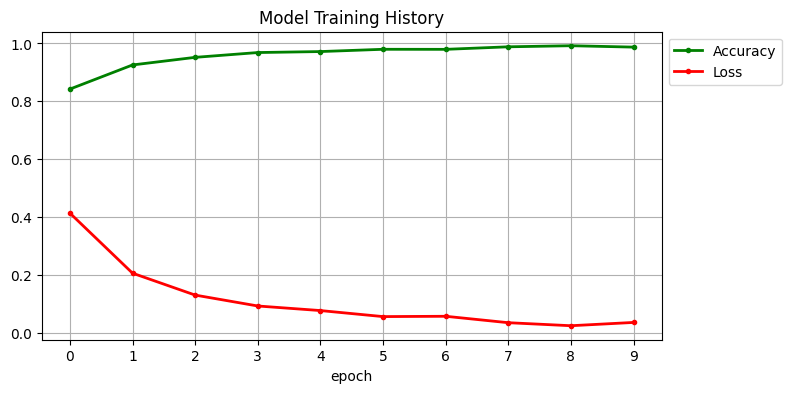

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Model Classification Report

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# 1. Prediction on test data
test_images = open_images(test_paths)  # Load and augment test images
test_labels_encoded = encode_label(test_labels)  # Encode the test labels

# Predict using the trained model
test_predictions = model.predict(test_images)

# 2. Classification Report
print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


ValueError: math domain error